# Contents
* [Introduction](#Introduction)
  * [FRILL](#FRILL)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Strata](#Strata)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Metaclassifier](#Metaclassifier)
* [Results](#Results)
  * [Classifier prediction correlations](#Classifier-prediction-correlations)
* [Discussion](#Discussion)

# Introduction

In this notebook, the most performant models and the tree-based methods from previous explorations are respectively ensembled. Scaling and resampling are introduced to mitigate class imbalance. The geometric mean metric is introduced in this notebook as well in addition to 5-fold cross validation.

A test harness is prepared for multinomial ternary classification. The results are visualized and discussed.

## FRILL

Here are two abstracts to introduce the FRILL embedding:

  [Towards Learning a Universal Non-Semantic Representation of Speech (2020)](#https://doi.org/10.21437/Interspeech.2020-1242)
> The ultimate goal of transfer learning is to reduce labeled data requirements by exploiting a pre-existing embedding model trained for different datasets or tasks. The visual and language communities have established benchmarks to compare embeddings, but the speech community has yet to do so. This paper proposes a benchmark for comparing speech representations on non-semantic tasks, and proposes a representation based on an unsupervised triplet-loss objective. The proposed representation outperforms other representations on the benchmark, and even exceeds state-of-the-art performance on a number of transfer learning tasks. The embedding is trained on a publicly available dataset, and it is tested on a variety of low-resource downstream tasks, including personalization tasks and medical domain. The benchmark, models, and evaluation code are publicly released.

  [FRILL: A Non-Semantic Speech Embedding for Mobile Devices (2021)](#https://arxiv.org/abs/2011.04609)
> Learned speech representations can drastically improve performance on tasks with limited labeled data. However, due to their size and complexity, learned representations have limited utility in mobile settings where run-time performance can be a significant bottleneck. In this work, we propose a class of lightweight non-semantic speech embedding models that run efficiently on mobile devices based on the recently proposed TRILL speech embedding. We combine novel architectural modifications with existing speed-up techniques to create embedding models that are fast enough to run in real-time on a mobile device and exhibit minimal performance degradation on a benchmark of non-semantic speech tasks. One such model (FRILL) is 32x faster on a Pixel 1 smartphone and 40% the size of TRILL, with an average decrease in accuracy of only 2%. To our knowledge, FRILL is the highest-quality non-semantic embedding designed for use on mobile devices. Furthermore, we demonstrate that these representations are useful for mobile health tasks such as non-speech human sounds detection and face-masked speech detection. Our models and code are publicly available.

FRILL is therefore a promising embedding since non-semantic aspects of speech signals is what distinguishes each class for this data. And it's fast!

Moreover, its output representation is a 2,048-element vector irrespective of input size. FRILL enables uniform handling of ragged sequences in an output format that is potentially more compact than spectrograms and MFCCs.

Furthermore, the FRILL representations are not time series, affording the full armamentarium of classifiers.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, f1_score

# scale & resample
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import OneSidedSelection

# cross validator
from sklearn.model_selection import StratifiedGroupKFold

# sklearn classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# other boosting classifiers
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 5.37 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 137 ms


# Data loading

In [5]:
keep_columns = [
    "id",
    "source",
    "speaker_id",
    "speaker_gender",
    "emo",
    "valence",
    "lang1",
    "length",
]

data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
labels = pd.read_feather(
    f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
).set_index("id")

time: 376 ms


In [6]:
# uncomment lines to undersample data
# data = data.sample(frac=0.02, random_state=SEED).sort_index()
# labels = labels.loc[data.index, :]

assert all(data.index == labels.index)
_ = gc_collect()

time: 151 ms


In [7]:
data.head(1)
data.info()
labels.head(1)
labels.info()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 138.4 MB


,source,speaker_id,speaker_gender,emo,valence,lang1,length
id,,,,,,,
0,aesdd,aesdd.1,f,ang,0,ell,medium


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          17703 non-null  category
 1   speaker_id      17703 non-null  category
 2   speaker_gender  17703 non-null  category
 3   emo             17703 non-null  category
 4   valence         17703 non-null  int8    
 5   lang1           17703 non-null  category
 6   length          17703 non-null  category
dtypes: category(6), int8(1)
memory usage: 321.6 KB
time: 227 ms


# Strata

In this section, strata are set up for the train-test split.

In [8]:
N_SPLITS = 5

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels[["source", "speaker_gender", "emo", "valence", "lang1", "length"]]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 17703/17703 [00:00<00:00, 47025.83it/s]

time: 452 ms


In [9]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    # convenience function
    strata_replace = lambda to_replace: strata.replace(
        to_replace, f"stratum_group_{count}", inplace=True
    )

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata_replace(strata_tuplet)
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata_replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]]
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata_replace((remainder.pop(), remainder.pop()))
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata_replace((shortside.pop(), longside.pop()))
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata_replace((remainder.pop(), remainder.pop()))
                    count += 1


_ = gc_collect()

time: 132 ms


In [10]:
process_strata(strata, n_splits=N_SPLITS)
strata.value_counts()

merge passes performed: 0
only 1: 28
only 2: 19
only 3: 10
only 4: 5
merge passes performed: 1
only 1: 23
only 2: 9
only 3: 0
only 4: 0
merge passes performed: 2
only 1: 14
only 2: 0
only 3: 9
only 4: 0
merge passes performed: 3
only 1: 5
only 2: 0
only 3: 0
only 4: 9
merge passes performed: 4
only 1: 0
only 2: 0
only 3: 0
only 4: 4
merge passes performed: 5
only 1: 0
only 2: 0
only 3: 0
only 4: 0


esdfsur0cmnmedium               984
esdfang0cmnmedium               982
esdfsad0cmnmedium               736
esdmhap2cmnmedium               689
esdfhap2cmnmedium               688
                               ... 
EmoReact_V_1.0fneu1engmedium      5
BAUM1fsad0turlong                 5
stratum_group_14                  5
stratum_group_10                  5
stratum_group_11                  5
Length: 168, dtype: int64

time: 429 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of cross validation such that the results may be easily cast to a `pandas` dataframe.

In [11]:
METRICS = (
    "avg_cv_balanced_accuracy",
    "avg_cv_f1",
    "avg_cv_geometric_mean",
    "avg_cv_fit_time",
    "avg_cv_predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {
    key: [] for key in {"model_name", "case", "resampled", *METRICS}
}
RESULTS = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    resampled: bool,
    model_name: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's score and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        "resampled": resampled,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


ALL_CASES = {"ternary"}

_ = gc_collect()

time: 196 ms


In [12]:
PREDICTIONS = {key: [] for key in {"model", "case", "resampled", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", PREDICTIONS.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 112 ms


The cross-validation splits are pre-computed to save time in the main loops.

In [13]:
CV_info = namedtuple(
    "CV_info",
    _ := "X_train X_test y_train y_test",
    defaults=[None] * len(_.split()),
)
assert all(data.index == strata.index)
assert all(strata.index == labels.index)
prepared_splits = [
    *StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED).split(
        X=data, y=strata, groups=labels.speaker_id
    )
]

scaler = StandardScaler()


def get_splits(case: str, resampled: bool = False) -> List[CV_info]:
    """Prepares the three-fold cross-validation splits ternary classification."""
    splits = []
    for train_idx, test_idx in prepared_splits:
        # select and scale
        X_train = scaler.fit_transform(data.iloc[train_idx])
        X_test = scaler.fit_transform(data.iloc[test_idx])
        y_train = labels.valence.iloc[train_idx]
        y_test = labels.valence.iloc[test_idx]

        if resampled:
            X_train, y_train = OneSidedSelection(
                random_state=SEED, n_jobs=-1
            ).fit_resample(
                *ADASYN(random_state=SEED, n_jobs=-1).fit_resample(X_train, y_train)
            )

        # reset indices
        splits.append(
            CV_info(
                X_train=X_train,
                y_train=y_train.reset_index(drop=True),
                X_test=X_test,
                y_test=y_test.reset_index(drop=True),
            )
        )
    return splits


data_chooser: Dict[str, List[CV_info]] = {case: get_splits(case) for case in ALL_CASES}
resampled_data_chooser: Dict[str, List[CV_info]] = {
    case: get_splits(case, resampled=True) for case in ALL_CASES
}

del scaler
_ = gc_collect()

time: 1min 47s


# Models

Thanks to FRILL, we may now use the gamut of classifiers provided by `sklearn`. Boosting methods outside of `sklearn` include `LightGBM` and `XGBoost`.

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

In [14]:
top_models = {
    "LogisticRegression": lambda: LogisticRegression(random_state=SEED, n_jobs=-1),
    "MLPClassifier": lambda: MLPClassifier(random_state=SEED),
    "RidgeClassifier": lambda: RidgeClassifier(random_state=SEED),
    "SGDClassifier": lambda: SGDClassifier(n_jobs=-1, random_state=SEED),
    "SVC": lambda: SVC(random_state=SEED),
}
tree_models = {
    "AdaBoostClassifier": lambda: AdaBoostClassifier(random_state=SEED),
    "LGBMClassifier": lambda: LGBMClassifier(
        boosting_type="rf",
        random_state=SEED,
        n_jobs=-1,
        subsample=0.75,
        subsample_freq=1,
    ),
    "RandomForestClassifier": lambda: RandomForestClassifier(
        n_jobs=-1, random_state=SEED
    ),
    "XGBClassifier": lambda: XGBClassifier(
        eval_metric="mlogloss", seed=SEED, use_label_encoder=False
    ),
}
models = {
    **top_models,
    **tree_models,
    "topStack": lambda: StackingClassifier(
        estimators=[(model, top_models[model]()) for model in top_models], n_jobs=-1
    ),
    "treeStack": lambda: StackingClassifier(
        estimators=[(model, tree_models[model]()) for model in tree_models], n_jobs=-1
    ),
    "DummyClassifier": lambda: DummyClassifier(random_state=SEED),
}
_ = gc_collect()

time: 165 ms


# Test harness

This section defines functions for evaluating models.

In [15]:
def evaluate_model(
    model_base: str, case: str, resample: bool = False, track_fold_time: bool = False
) -> AvgScores:
    """Evaluate a binary classification model with three-fold stratified grouped cross validation."""

    fit_times, predict_times, balanced_accuracy, f1, geometric_mean = [], [], [], [], []
    selected_data: List[CV_info] = (
        resampled_data_chooser[case] if resample else data_chooser[case]
    )
    for fold_num in range(N_SPLITS):
        if track_fold_time:
            fold_begin = time()

        # obtain prepared folds
        fold_data: CV_info = selected_data[fold_num]

        # define train
        X_train = fold_data.X_train
        y_train = fold_data.y_train

        # define test
        X_test = fold_data.X_test
        y_test = fold_data.y_test

        # initialize binary model
        model = models[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        fit_times.append(end - begin)

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()

        # store prediction results
        predict_times.append(end - begin)
        store_prediction(
            where=PREDICTIONS,
            prediction=Prediction(
                model=model_base,
                case=case,
                resampled=resample,
                fold=fold_num,
                y_pred=predicted,
            ),
        )

        # score
        score_params = {"y_true": y_test, "y_pred": predicted}
        balanced_accuracy.append(balanced_accuracy_score(**score_params))
        f1.append(f1_score(**score_params, average="weighted"))
        geometric_mean.append(geometric_mean_score(**score_params))

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )

        # free some memory
        del begin
        del end
        del model
        del predicted
        del score_params
        del X_test
        del X_train
        del y_test
        del y_train
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (balanced_accuracy, f1, geometric_mean, fit_times, predict_times)
        ]
    )


_ = gc_collect()

time: 117 ms


The next cell evaluates models.

In [16]:
case = "ternary"
for model in tqdm(models):
    for resample in {True, False}:
        store_result(
            where=RESULTS,
            case=case,
            resampled=resample,
            model_name=model,
            avg_scores=evaluate_model(
                model, case, resample=resample, track_fold_time=True
            ),
        )
        print(f"stored {model} for {case} classification")
        _ = gc_collect()

  0%|          | 0/12 [00:00<?, ?it/s]

LogisticRegression fold 1 completed in 4.20 s
LogisticRegression fold 2 completed in 4.27 s
LogisticRegression fold 3 completed in 4.01 s
LogisticRegression fold 4 completed in 3.56 s
LogisticRegression fold 5 completed in 3.63 s
stored LogisticRegression for ternary classification
LogisticRegression fold 1 completed in 6.15 s
LogisticRegression fold 2 completed in 5.56 s
LogisticRegression fold 3 completed in 5.92 s
LogisticRegression fold 4 completed in 5.63 s
LogisticRegression fold 5 completed in 5.63 s
stored LogisticRegression for ternary classification
MLPClassifier fold 1 completed in 31.56 s
MLPClassifier fold 2 completed in 31.32 s
MLPClassifier fold 3 completed in 30.15 s
MLPClassifier fold 4 completed in 28.13 s
MLPClassifier fold 5 completed in 28.36 s
stored MLPClassifier for ternary classification
MLPClassifier fold 1 completed in 17.11 s
MLPClassifier fold 2 completed in 16.74 s
MLPClassifier fold 3 completed in 16.71 s
MLPClassifier fold 4 completed in 15.74 s
MLPClass

Let's peek at the results.

In [17]:
results_df = (
    pd.DataFrame(RESULTS)
    .sort_values(by=["resampled", "model_name"])
    .reset_index(drop=True)
)
results_df

,avg_cv_f1,case,avg_cv_fit_time,avg_cv_geometric_mean,resampled,avg_cv_predict_time,avg_cv_balanced_accuracy,model_name
0,0.489925,ternary,166.156979,0.381992,False,0.151441,0.436294,AdaBoostClassifier
1,0.396673,ternary,0.003931,0.000000,False,0.000200,0.333333,DummyClassifier
2,0.484133,ternary,37.074119,0.281401,False,0.123886,0.412950,LGBMClassifier
3,0.566600,ternary,3.892754,0.504660,False,0.033578,0.530355,LogisticRegression
4,0.601135,ternary,29.881433,0.538076,False,0.020608,0.564392,MLPClassifier
5,0.433583,ternary,5.278846,0.120878,False,0.076105,0.363839,RandomForestClassifier
6,0.569395,ternary,0.934815,0.502885,False,0.006250,0.527575,RidgeClassifier
7,0.544043,ternary,46.384052,0.458319,False,0.077232,0.508141,SGDClassifier
8,0.581614,ternary,6.878221,0.457266,False,1.321024,0.526099,SVC
9,0.543777,ternary,454.432609,0.400124,False,0.079457,0.481545,XGBClassifier


time: 50.4 ms


# Results

In this section, we create several visualizations to display the results.

In [18]:
metric_names = {
    "avg_cv_balanced_accuracy": "balanced accuracy",
    "avg_cv_f1": "F1 score",
    "avg_cv_fit_time": "fit time",
    "avg_cv_geometric_mean": "geometric mean",
    "avg_cv_predict_time": "predict time",
}


def plot_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the dummy classifier is omitted since it is always the fastest.
        # Likewise, the stacking classifiers are omitted since they are usually the slowest.
        results_df = results_df.loc[~results_df.model_name.str.contains(r"Dummy|Stack")]
    results_df.model_name = results_df.model_name.str.replace("Classifier", "")
    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="resampled",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        legend=False,
        alpha=0.8,
    )
    plt.legend(loc="upper center", frameon=False, title="resampled")  # reset legend
    if not time_metric:
        plt.ylim(0, 1)
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    plt.xlabel("")
    plt.ylabel("")
    plt.suptitle(f"{metric_names[metric]}{' (s)' if time_metric else ''}")
    plt.tight_layout()
    plt.show()

time: 3.24 ms


  0%|          | 0/5 [00:00<?, ?it/s]

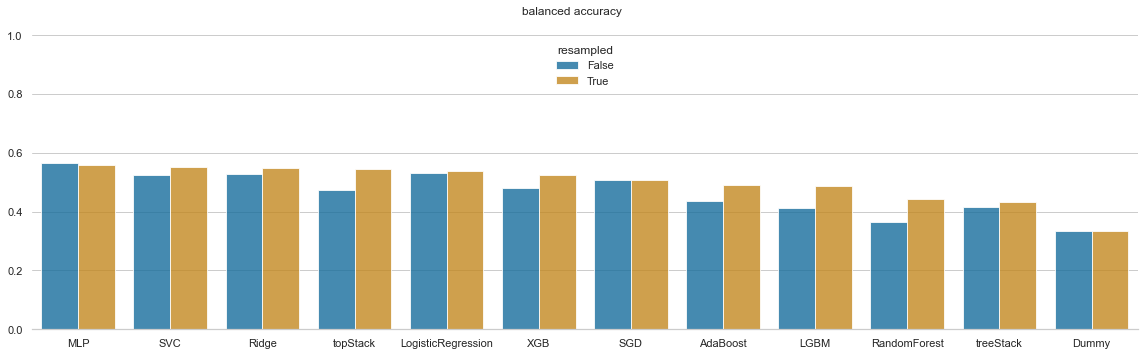

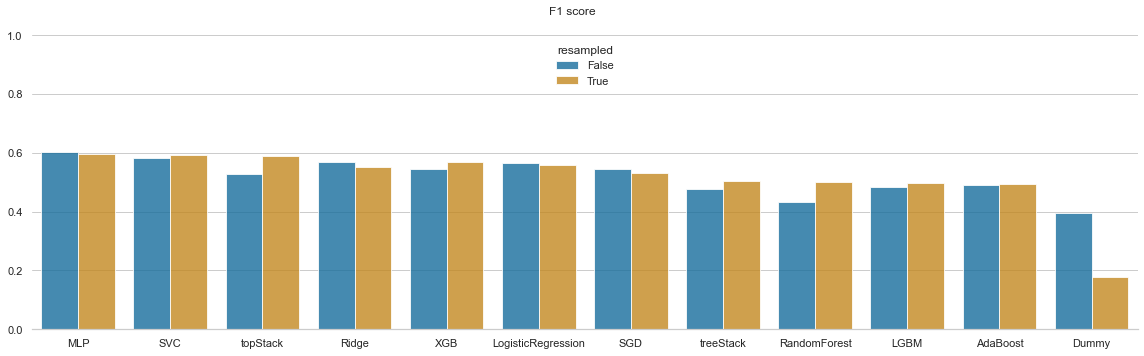

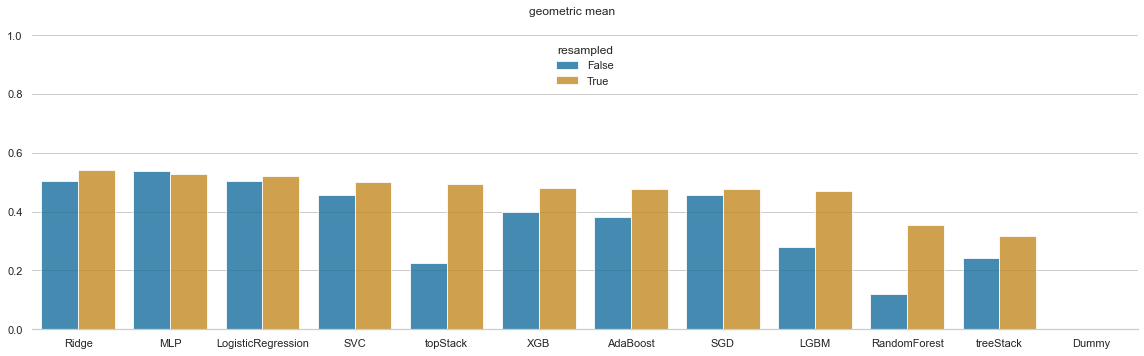

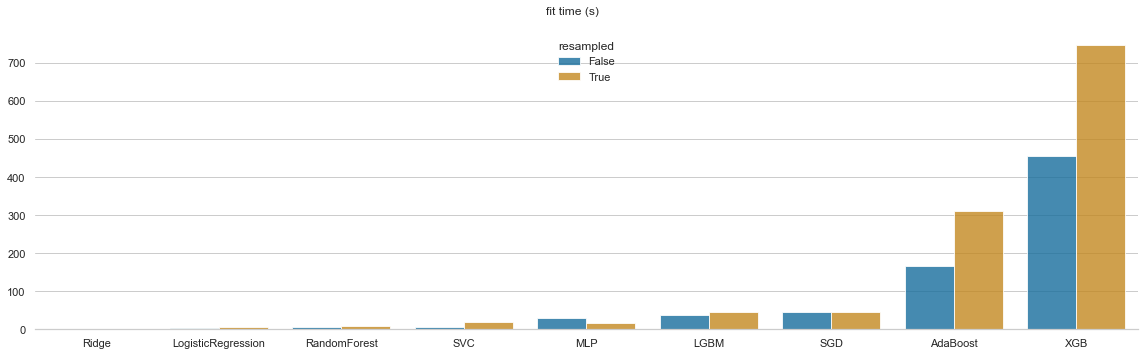

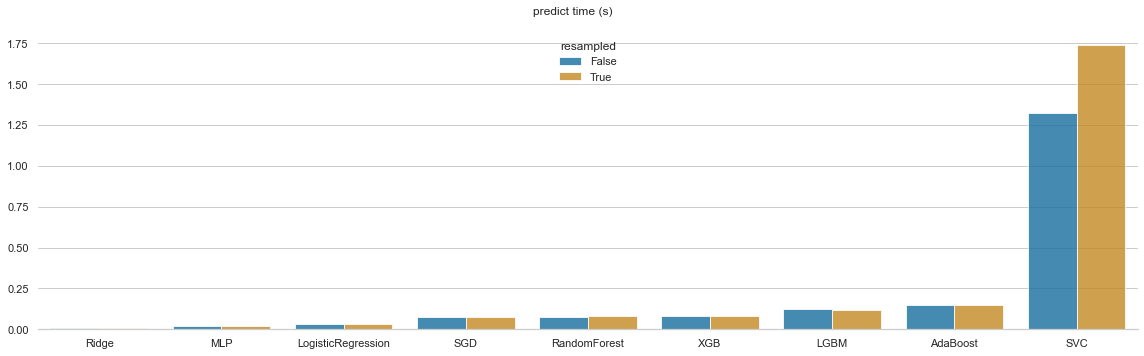

time: 2.27 s


In [19]:
for metric in tqdm(METRICS):
    plot_metric(metric, results_df)

## Classifier prediction correlation

In this section, we assess the correlation between each model's predictions. Performant and uncorrelated models are ideal for a potential stacked classifier.

For each case, pairwise Pearson correlations are calculated between model predictions and the absolute values of the correlation coefficients averaged over the folds. This is not a statistically pure approach since better methods for assessing categorical correlations (e.g., Cramer's V or Theil's U) exist and the Fisher's Z transformation was omitted, but it should be good enough; we just need to assess co-occurence to see which are most unassociated.

In [20]:
prediction_correlations = {}
predictions_df = pd.DataFrame(PREDICTIONS)

for resample in {True, False}:
    case_df = predictions_df.query(f"resampled == {resample}")
    fold_correlations = []
    for fold in range(N_SPLITS):
        df = case_df.query(f"fold == {fold}")
        df = (
            pd.DataFrame(
                {
                    # deleting Classifier makes for less cluttered visualization
                    model.replace("Classifier", ""): df.loc[
                        df.model == model, "y_pred"
                    ].item()
                    for model in np.unique(df.model)
                }
            )
            .corr()
            .swifter.apply(abs)
        )
        fold_correlations.append(df)
        del df
        _ = gc_collect()
    prediction_correlations[case] = (
        (_ := pd.concat(fold_correlations)).groupby(_.index).mean()
    )
    del case_df
    del fold_correlations
    _ = gc_collect()

Pandas Apply: 100%|██████████| 12/12 [00:00<?, ?it/s]


time: 1.76 s


In [21]:
def plot_prediction_correlations(case: str, drop_dummy: bool = True) -> None:
    """Plot heatmap for prediction correlations."""
    plt.figure(figsize=(15, 15))
    df = (
        prediction_correlations[case]
        .dropna(axis="columns", how="all")
        .dropna(axis="index", how="all")
        # classifiers whose predictions do not vary (e.g., dummy) produce NaN correlations and are dropped from visualization
    )
    if drop_dummy:
        df = df.loc[~df.index.isin(df.filter(like="Dummy", axis="index").index)]
        df.drop(columns=df.filter(like="Dummy", axis="columns").columns, inplace=True)
    g = sns.heatmap(
        data=df,
        vmin=0,
        vmax=1,
        cmap="coolwarm",
        square=True,
        mask=np.triu(np.ones_like(df, dtype=bool)),
    )
    plt.suptitle(f"{case} prediction correlations")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    del df
    del g
    _ = gc_collect()


_ = gc_collect()

time: 122 ms


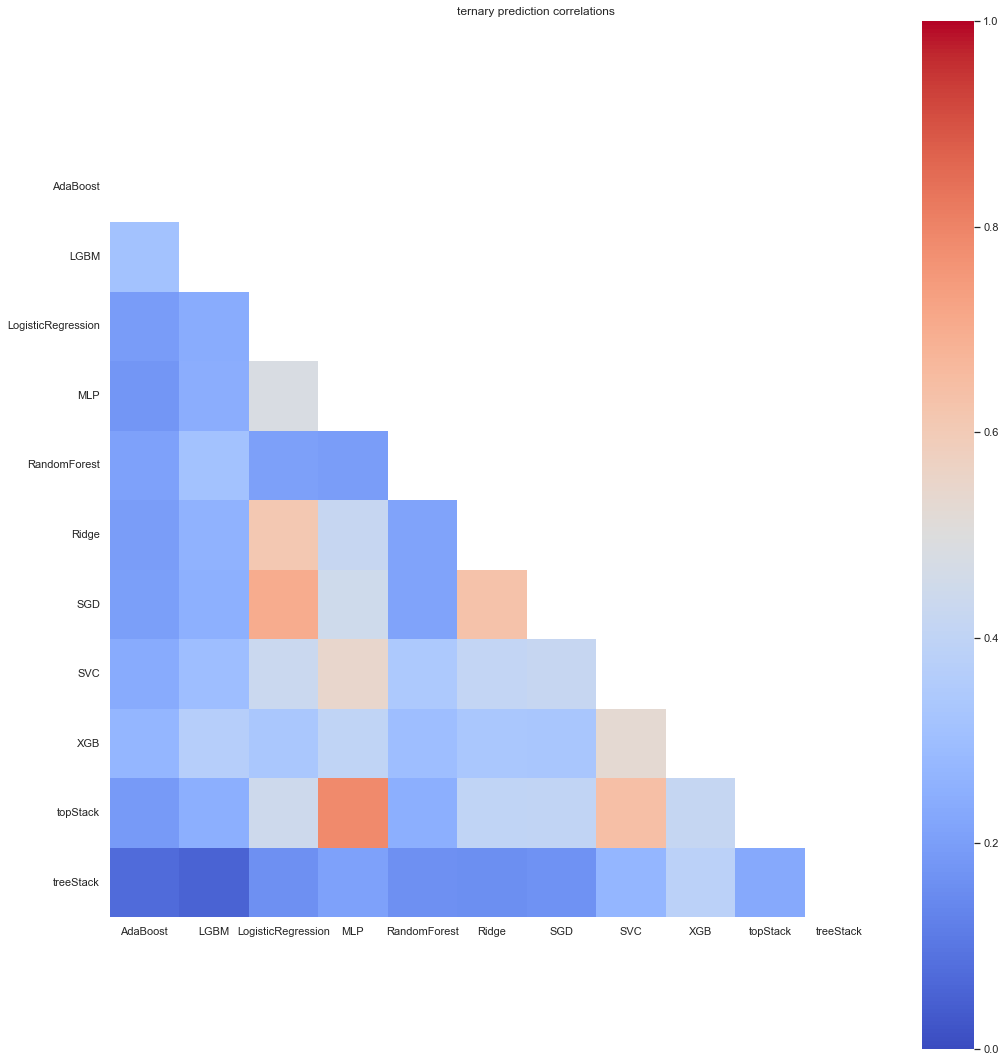

time: 517 ms


In [22]:
for case in ALL_CASES:
    plot_prediction_correlations(case)

In [23]:
# save table of results
results_df.to_csv(
    f"{DATA_OUT_FOLDER}/explore_hybrid_multiclass_results_CV{N_SPLITS}.csv"
)

time: 7 ms


# Discussion

These scores are middling, but almost all estimators outperformed the dummies. The geometric mean metric is useful in that it describes the dummy classifiers as unskilled with a zero score, so the geometric mean scores of the other models have a dummy-calibrated baseline. The geometric mean makes it easier to answer the question, "How much better than a dummy did this model perform?" while affording relative comparison between skilled models.

This notebook demonstrates that resampling can boost performance for many of the models considered although this benefit may not be applicable to the MLP classifiers. Otherise, when model and classification task are held constant, observed performance has been roughly equivalent between notebooks in general. Nonetheless, these results must be regarded skeptically; for each train test split, a separate Standard Scaler was fit for the train and the test data whereas it is more appropriate to fit the scaler once on the train data and use it to scale both the train and test data. This is an important point to address in refactoring.

The vanilla MLP from sklearn is again one of the top contenders; the highest balanced accuracy in ternary classification (just over .56) was achieved by the MLP in this notebook. This leaves open the possibility of pursuing a pure deep learning approach; I imagine a straightforward dense net with one or two hidden layers could be tuned. Yet, its scores lead only by a thin margin with models that train or predict faster closely following. In fact, the Ridge Classifier actually outperformed the MLP (by geometric mean) after resampling and was the fastest algorithm in both training and prediction. Although the MLP keeps showing up as a strong contender and thus warrants further investigation, it may be premature to discount the runner ups.

Since the runner ups include several linear models, PCA to condense the FRILL representations may be appropriate to explore.

On the other hand, random forest has displayed only marginal skill relative to the dummy (and incidentally benefits the most from resampling). If the tree-based classifiers are ensembled, the random forest models may be candidates for omission. Further, XGBoost alone may outperform any tree-based meta-ensemble we could construct from these classifiers. However, the training time of XGBoost is an obstacle; there may be some configuration hyperparameters that could be adjusted to constrain fit times.

The heatmap reveals that the predictions of the top stack and the MLP are correlated. On the other hand, the plots above the heatmap reveal that the MLP outperforms the stack.

In [24]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 45999.20693087578 s
time: 106 ms


[^top](#Contents)